# Task 1

In [ ]:
! pip install tensorflow --upgrade

     |████████████████████████████████| 462 kB 26.9 MB/s 


## a) 

### The energy function of Restricted Boltzmann machine is given by:

\begin{equation*}
E( v,\ h) \ =\ -b^{T} v-c^{T} h-v^{T} Wh
\end{equation*}
where $h$ is the hidden layer, $v$ is the visible layer, $b$ and $c$ are bias vectors. 

### The probability distribution 
\begin{equation*}
p( v,\ h) \ =\ \frac{1}{z} exp\{-E( v,\ h)\}
\end{equation*} 
is determined by the energy function where '$Z$ is the normalizing function'.
<br> \

### $Z$ is given as 

\begin{equation*}
 \ \sum _{v}\sum _{h} exp\{-E( v,\ h)\}
\end{equation*}
<br>
$Z$ contains the energy function, and it's invesely proportional to the probability distribution. So to decrease the energy function, the probability distribution $\displaystyle p( v,\ h)$ should be increased. 

\
Now we bring in '$x$', which is a non-observed and is partially observable.
We sum the initial equation over '$h$' on both the sides : 

\begin{equation*}
p( x) \ =\ \sum _{h}\sum _{v} p( x,\ h) \ =
 \ \sum _{h}\sum _{v} exp\{-E( x,\ h)\}=\ \sum _{h}\frac{e^{-E( x,\ h)}}{Z} \quad \quad
\end{equation*}

Also,
\begin{equation}
F( x) \ =\ -\log\sum _{h} exp\{-E( x,\ h)\} =\ -\log\sum _{h} e^{-E( x,\ h)} \quad \quad 
\end{equation}

### Here, $F(X)$ is called Free energy.

### Substituting $F(X)$ in $p(X)$ and differentiation with respect to 'Θ',

\begin{equation*}
\frac{\partial \log p( x)}{\partial \theta }  = -\sum p( x')\frac{\partial F( x')}{\partial \theta }
\end{equation*}
So, 
\begin{equation*}
E( v,\ h)  = -\sum _{k} b_{k} v_{k} -\sum _{j} c_{j} h_{j} -\sum _{j}\sum _{k} W_{jk} h_{j} v_{k}
\end{equation*}
Now, to decrease the energy function and maximize probability, the terms containing '$b$ and $c$' should be maximized. Here $Z$ and the marginal probability distribution $p(v)$ are both untractable. Therefore, we perform sampling on the conditional probabilities - $\displaystyle p( h|v)$ and $\displaystyle p( v|h)$. This type of sampling is called 'Gibbs Sampling'.

\begin{equation}
P(h|v) = \prod _{j} p( h_{j} |v) 
      = \frac{P(h,v)}{P(v)}
\end{equation}

\begin{equation}
    = \frac{1}{Z'} \Pi_j exp \{ c_j h_j + v^T W_j h_j\}
\end{equation}


\begin{equation}
P(h_j = 1,v) = \frac{\hat{P}(h_j = 1,v)}{\hat{P}(h_j = 0,v) + \hat{P}(h_j = 1,v)}
\end{equation} 

\begin{equation}
P(h_j = 1|v) = \sigma(c_j + v^T W_j ) = \frac{1}{Z'} exp\{\Sigma_j c_j h_j + \Sigma_j v^T W_j h_j \}
\end{equation} \

Now, for $p(v|h)$ : 
\begin{equation}
P(v|h) = \prod _{k} p( v_{k} |h)= \frac{P(v,h)}{P(h)} = \frac{1}{Z'} \Pi_k exp \{b_k + h^T W_k \}
\end{equation}
\begin{equation}
P(v_k = 1|h) = \sigma(b_k + h^T W_k)
\end{equation}

\begin{equation}
    = \frac{1}{Z'} exp\{c^T h + v^{T} W h\}
\end{equation}

## b)


In [52]:
#importing libraries
import numpy as np
import tensorflow as tf
import torch
import torch.utils.data
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Reshape, Conv2DTranspose, Dropout, Activation
from keras import backend as K
from keras.losses import mse, binary_crossentropy
from keras.utils import np_utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from keras.models import Sequential, Model
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop
import random
%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from scipy.stats import norm
import matplotlib.patches as mptaches
import pandas as pd

#importing MNIST dataset
batch_size = 64
train_load = torch.utils.data.DataLoader(datasets.MNIST('./data',train=True,download = True,transform = transforms.Compose([transforms.ToTensor()])),batch_size=batch_size)
test_load = torch.utils.data.DataLoader(datasets.MNIST('./data',train=False,transform=transforms.Compose([transforms.ToTensor()])),batch_size=batch_size)

In [53]:
#define rbm class
class RBM(nn.Module):
   #initialization function
   def __init__(self,visible_units=784,hidden_units=100,cycles=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(hidden_units,visible_units)*1e-2)
        self.c = nn.Parameter(torch.zeros(visible_units))
        self.b = nn.Parameter(torch.zeros(hidden_units))
        self.cycles = cycles
   def sampling_(self,prob):
       return F.relu(torch.sign(prob - Variable(torch.rand(prob.size()))))
   def forward_(self,visible):
        prob_h = F.sigmoid(F.linear(visible,self.W,self.b))
        sample_h = self.sampling_(prob_h)
        return prob_h,sample_h
   def back_(self,hidden):
        prob_v = F.sigmoid(F.linear(hidden,self.W.t(),self.c))
        sample_v = self.sampling_(prob_v)
        return prob_v,sample_v
   def forward(self,visible):
        pre_h1,h1 = self.forward_(visible)
        hidden_ = h1
        for _ in range(self.cycles):
            pre_v_,visible_ = self.back_(hidden_)
            pre_h_,hidden_ = self.forward_(visible_)
        return visible,visible_
   def energy_function(self,visible):
        vbias_term = visible.mv(self.c)
        wx_b = F.linear(visible,self.W,self.b)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

In [54]:
def plot(img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(npimg)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


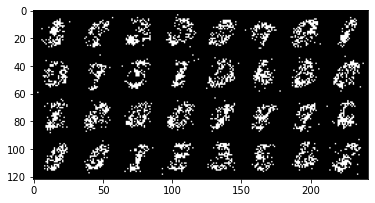

In [56]:
# 20 Hidden units
r = RBM(hidden_units=20)
train_ = optim.SGD(r.parameters(),0.01)
for e in range(10):
    loss_ = []
    for _, (d,t) in enumerate(train_load):
        d = Variable(d.view(-1,784))
        sample_d = d.bernoulli()
        v,v1 = r(sample_d)
        loss = r.energy_function(v) - r.energy_function(v1)
        train_.zero_grad()
        loss.backward()
        train_.step()
plot(make_grid(v1.view(32,1,28,28).data))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


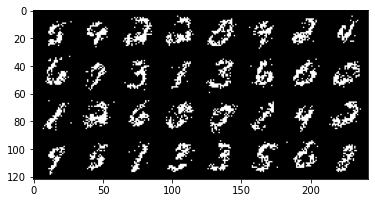

In [57]:
# 100 hidden units
r = RBM(hidden_units=100)
train_ = optim.SGD(r.parameters(),0.01)
for e in range(10):
    loss_ = []
    for _, (d,t) in enumerate(train_load):
        d = Variable(d.view(-1,784))
        sample_d = d.bernoulli()
        v,v1 = r(sample_d)
        loss = r.energy_function(v) - r.energy_function(v1)
        train_.zero_grad()
        loss.backward()
        train_.step()
plot(make_grid(v1.view(32,1,28,28).data))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


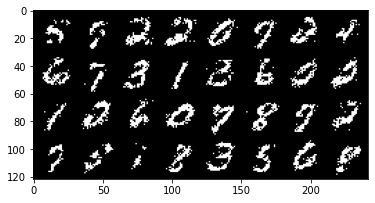

In [67]:
# 500 hidden units
r = RBM(hidden_units=500)
train_ = optim.SGD(r.parameters(),0.01)
for e in range(10):
    loss_ = []
    for _, (d,t) in enumerate(train_load):
        d = Variable(d.view(-1,784))
        sample_d = d.bernoulli()
        v,v1 = r(sample_d)
        loss = r.energy_function(v) - r.energy_function(v1)
        train_.zero_grad()
        loss.backward()
        train_.step()
plot(make_grid(v1.view(32,1,28,28).data))

## c)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


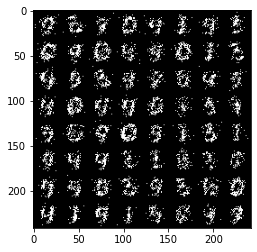

In [60]:
# After removing 20% Pixels
examples = enumerate(test_load)
batch_idx, (example_d, example_t) = next(examples)
for i in range(64):
  for j in range(int(784*0.2)):
    example_d[2][0][np.random.randint(0,high=27)][np.random.randint(0,high=27)] = 0
r = RBM(hidden_units=500)
train_SGD = optim.SGD(r.parameters(),0.01)
for e in range(500):
    loss_ = []
    d = Variable(example_d.view(-1,784))
    sample_d = d.bernoulli()   
    v,v1 = r(sample_d)
    loss = r.energy_function(v) - r.energy_function(v1)
    train_SGD.zero_grad()
    loss.backward()
    train_SGD.step()
plot(make_grid(v1.view(64,1,28,28).data))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


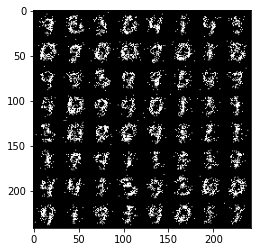

In [61]:
# After removing 50% pixels
examples = enumerate(test_load)
batch_idx, (example_d, example_t) = next(examples)
for i in range(64):
  for j in range(int(784*0.5)):
    example_d[2][0][np.random.randint(0,high=27)][np.random.randint(0,high=27)] = 0
r = RBM(hidden_units=500)
train_SGD = optim.SGD(r.parameters(),0.01)
for e in range(500):
    loss_ = []
    d = Variable(example_d.view(-1,784))
    sample_d = d.bernoulli()
    v,v1 = r(sample_d)
    loss = r.energy_function(v) - r.energy_function(v1)
    train_SGD.zero_grad()
    loss.backward()
    train_SGD.step()
plot(make_grid(v1.view(64,1,28,28).data))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


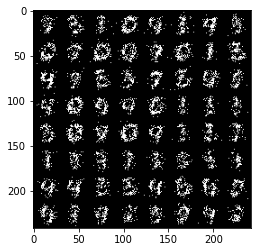

In [62]:
# After removing 80% pixels
examples = enumerate(test_load)
batch_idx, (example_d, example_t) = next(examples)
for i in range(64):
  for j in range(int(784*0.8)):
    example_d[2][0][np.random.randint(0,high=27)][np.random.randint(0,high=27)] = 0
r = RBM(hidden_units=500)
train_SGD = optim.SGD(r.parameters(),0.01)
for e in range(500):
    loss_ = []
    d = Variable(example_d.view(-1,784))
    sample_d = d.bernoulli()
    v,v1 = r(sample_d)
    loss = r.energy_function(v) - r.energy_function(v1)
    train_SGD.zero_grad()
    loss.backward()
    train_SGD.step()
plot(make_grid(v1.view(64,1,28,28).data))

# Task 2


## a)

### The posterior probability,

$$P\left( z|x \right) = \frac{P\left(x|z\right) P(z)}{P(x)}$$
$$ = \frac{P\left(x,z\right)}{P(x)}$$
where $Z$ is the hidden variable, and X is the observation. \

We need to find the normalizing factor $P(x)$.
Variational Inference is used to find this factor, since it involves huge computation over the other factors $P(x|Z)$,$P(z)$. \

Here $q(z)$ is used as an additional distribution to solve this issue. Considering it to be a tractable distribution, we can fine tune its parameters. The idea behind this, is to make it close to the orignial distribution. KL-divergence technique is used for this. 

### $$KL\left(q(z)||P(z|x)\right) = - \sum q\left(z\right) log \frac{P(z|x)}{q(z)}$$ 
Substituting the value for $P(z|x)$,

$$KL\left(q(z)||P(z|x)\right) = - \sum q(z) log \frac{P(x,z)}{q(z)} .\frac {1}{P(x)}$$
$$KL\left(q(z)||P(z|x)\right) = - \sum q(z) \left[log \frac{P(x,z)}{q(z)} - log P(x)\right]$$
$$KL\left(q(z)||P(z|x)\right) = - \sum q(z) log \frac{P(x,z)}{q(z)} + log P(x) \sum_{z} q(z)$$
since $\sum_{z} q(z) = 1$,
$$KL\left(q(z)||P(z|x)\right) = - \sum q(z) log \frac{P(x,z)}{q(z)} + log P(x)$$
<br>
Which would give us the value of $log P(x)$ being 
$$KL\left(q(z) || P(z|x)\right) + \sum q(z) log\frac{ P\left(x,z\right)}{q(z)}$$ \
Let the term $\sum q(z) log\frac{ P\left(x,z\right)}{q(z)}$ be $L$. \
$log P(x)$ is constant. \
<br>
$$\ log P(x) = KL-divergence + L$$
Which would mean,
$$\ constant = KL-divergence + L$$
<br>
For KL-divergence to be maximised, we can maximize L. \
Here,
$L <= P(x)$(constant). 

Working on $L$:
$$L=\sum q(z) log \frac{P(x,z)}{q(z)}$$
$$P(x,z) = P(x|z)p(z)$$
Therefore, 
$$L = \sum q(z) log \frac{P(x|z) P(z)}{q(z)}$$
$$ = \sum q(z) \left[log P(x|z) + \frac{P(z)}{q(z)}\right]$$
$$L = \sum q(z) log P(x|z) \sum q(z) log\frac{P(z)}{q(z)}$$

The first term is the expectation term between '$log P(x|z)$' and '$q(z)$'.

The objective function is :

$$E_{q(z)} log P(x|z) - KL \left( q(z) || P(z) \right)$$ 

For the auto-encoder, let $q$ be a  neural network, with inputs $x$ producing $z$ mappings. Let $P$ be another neural network with $z$ input producing $x^{'}$ mappings.  

This Auto-encoder setup can be represented as : 
$$ x \rightarrow NeuralNetwork \left(q(z|x)\right) \rightarrow z \rightarrow NeuralNetwork \left(p(x|z)\right) \rightarrow x^{'} $$

The first neural network is a construction error. \
The second NN is a deterministic model. So the relationship between $z$ and $x^{'}$ stays the same. Thus, $P(x|z)$ can be replaced by $P(x|x^{'})$.

Now, $P(x|x^{'})$ can be represented by
$e^{-\left|x-x^{'}\right|^{2}}$ since the distribution is Gaussian.

Taking log for the above equation, $P(x|x^{'}) = \left|x-x^{'}\right|^2$

Substituting this in the objective function, we get 
$min  \left|x-x^{'}\right|^{2} + KL\left( q(z|x) || N(    )\right)$, where $N(    )$ is Gaussian.

$z$ has a Normal distribution having parameters $\mu$ and $\sigma$. $\sigma$ is $[DxD]$ and $\mu$ is a D-dimensional vector.  

This is a $Generative$ $Model$ producing mean and variance on each neural network. 

#### Thus we have designed a $Variational Auto-encoder$.

## b),c)

In [74]:
#importing dataset from MNIST
(train_x, train_y), (test_x, test_y) = mnist.load_data()
img_size = train_x.shape[1]
original_dim = img_size * img_size
train_x = np.reshape(train_x, [-1, original_dim])
test_x = np.reshape(test_x, [-1, original_dim])
train_x= train_x.astype('float32') / 255
test_x = test_x.astype('float32') / 255
input_shape = (original_dim, )
batch_size = 128

In [75]:
def l_sampling(args):
    z_mean_layer, z_log_var_layer = args
    batch = K.shape(z_mean_layer)[0]
    dimension = K.int_shape(z_mean_layer)[1]
    ep = K.random_normal(shape=(batch, dimension))
    return z_mean_layer + K.exp(0.5 * z_log_var_layer) * ep

In [76]:
def c_model(hidden_node, latent_node):
    encoder_inputs = Input(shape=input_shape, name='input_encoder')
    encoder_hidden = Dense(hidden_node, activation='relu')(encoder_inputs)
    z_mean = Dense(latent_node, name='z_mean')(encoder_hidden)
    z_log_var = Dense(latent_node, name='z_log_var')(encoder_hidden)
    z = Lambda(l_sampling, output_shape=(latent_node,), name='z')([z_mean, z_log_var])
    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()

    latent_encoder_inputs = Input(shape=(latent_node,), name='l_sampling')
    decoder_hidden = Dense(hidden_node, activation='relu')(latent_encoder_inputs)
    decoder_outputs = Dense(original_dim, activation='sigmoid')(decoder_hidden)
    decoder = Model(latent_encoder_inputs, decoder_outputs, name='decoder')
    decoder.summary()

    model_outputs = decoder(encoder(encoder_inputs)[2])
    vae = Model(encoder_inputs, model_outputs, name='vae_mlp')
    reconstruction_loss = binary_crossentropy(encoder_inputs, model_outputs)
    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    return vae, encoder, decoder

In [77]:
def t_model(model):
    trained_model = model.fit(train_x, epochs=epochs,batch_size=batch_size,validation_data=(test_x, None))
    return trained_model 

In [78]:
def plot_ls(encoder):
    z_test, _, _ = encoder.predict(test_x, batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_test[:, 0], z_test[:, 1], c=test_y)
    plt.colorbar()
    plt.xlabel("Z[0]")
    plt.ylabel("Z[1]")
    plt.savefig("VAE")
    plt.show()

In [79]:
def plot_vae(decoder,latent_dim):
    n = 20
    digit_num = 28
    figure = np.zeros((digit_num * n, digit_num * n))
    axis_x = np.linspace(-3, 3, n)
    axis_y = np.linspace(-3, 3, n)[::-1]    
    for i, yi in enumerate(axis_y):
        for j, xi in enumerate(axis_x):
            if(latent_dim == 2):
                latent_sample = np.array([[xi, yi]*int(latent_dim/2)])
            else:
                latent_sample = np.random.normal(0,1,size=[batch_size, latent_dim])
            input_decoded = decoder.predict(latent_sample)
            digit = input_decoded[0].reshape(digit_num, digit_num)
            figure[i * digit_num: (i + 1) * digit_num,
                   j * digit_num: (j + 1) * digit_num] = digit
    
    plt.figure(figsize=(10, 10))
    i_range = digit_num // 2
    j_range = (n - 1) * digit_num + i_range + 1
    pixel_range = np.arange(i_range, j_range, digit_num)
    sample_range_x = np.round(axis_x, 1)
    sample_range_y = np.round(axis_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.imshow(figure, cmap='Greens_r')
    plt.savefig("VAE_Output")
    plt.show()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_encoder (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 dense_55 (Dense)               (None, 256)          200960      ['input_encoder[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 2)            514         ['dense_55[0][0]']               
                                                                                                  
 z_log_var (Dense)              (None, 2)            514         ['dense_55[0][0]']               
                                                                                            

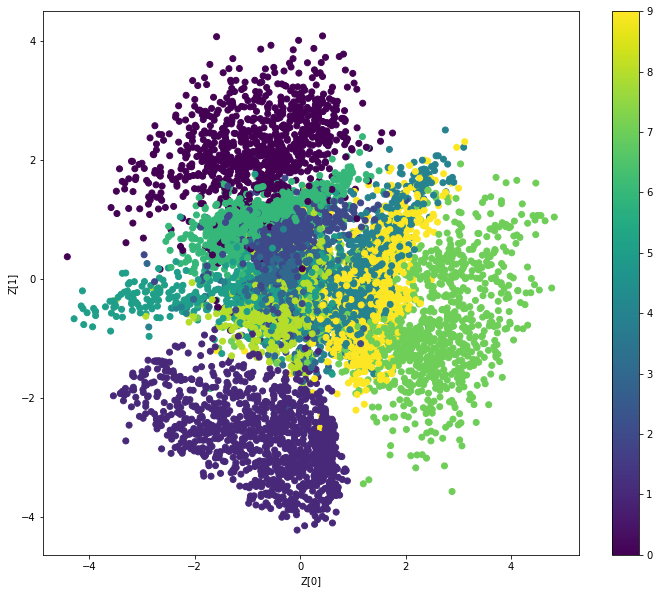

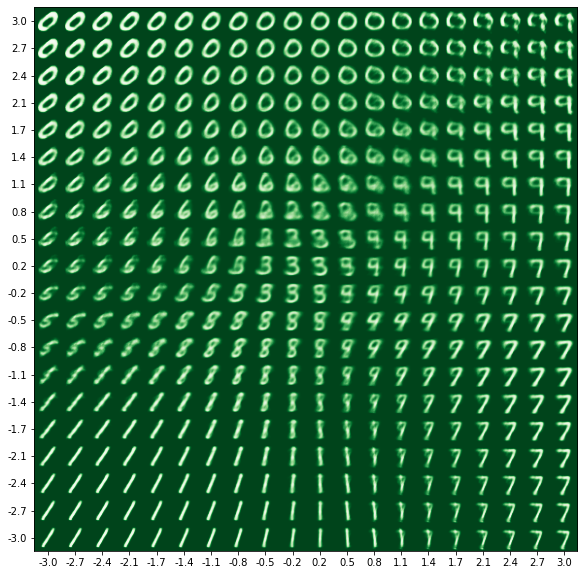

In [66]:
#VAE with 2 code units
i_dim = 256
l_dim = 2 
epochs = 20
vae, encoder, decoder = c_model(i_dim, l_dim)
trained_model = t_model(vae)
plot_ls(encoder)
plot_vae(decoder, l_dim)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_encoder (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 dense_46 (Dense)               (None, 256)          200960      ['input_encoder[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 8)            2056        ['dense_46[0][0]']               
                                                                                                  
 z_log_var (Dense)              (None, 8)            2056        ['dense_46[0][0]']               
                                                                                            

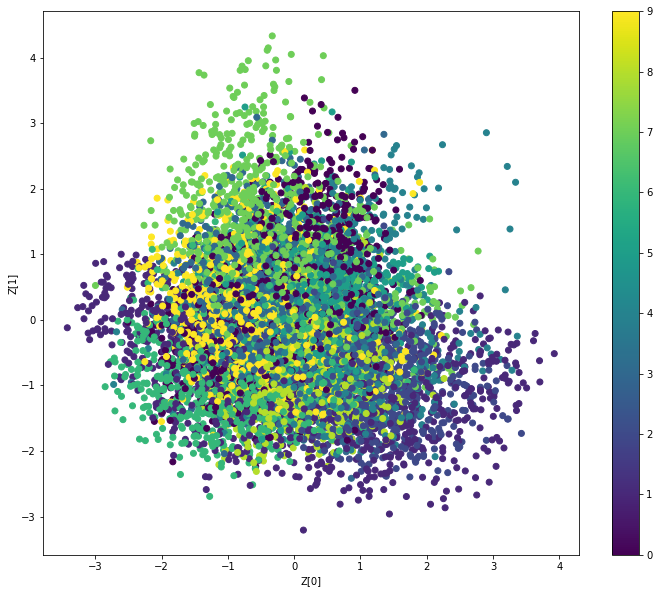

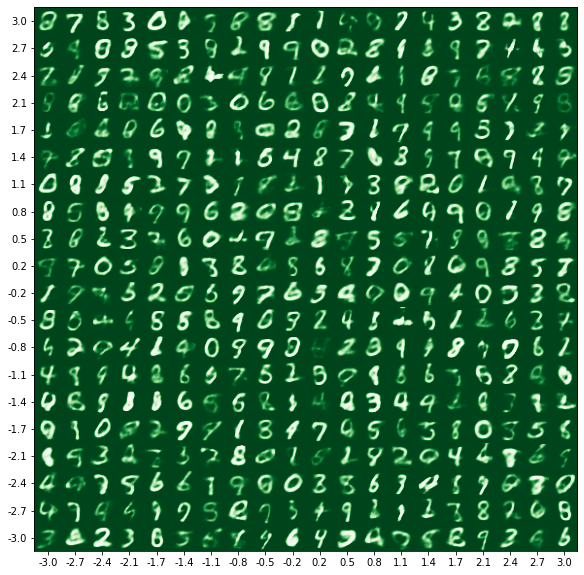

In [48]:
#VAE with 8 code units
i_dim = 256
l_dim = 8 
epochs = 20
vae, encoder, decoder = c_model(i_dim, l_dim)
trained_model = t_model(vae)
plot_ls(encoder)
plot_vae(decoder, l_dim)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_encoder (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 dense_52 (Dense)               (None, 256)          200960      ['input_encoder[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 16)           4112        ['dense_52[0][0]']               
                                                                                                  
 z_log_var (Dense)              (None, 16)           4112        ['dense_52[0][0]']               
                                                                                            

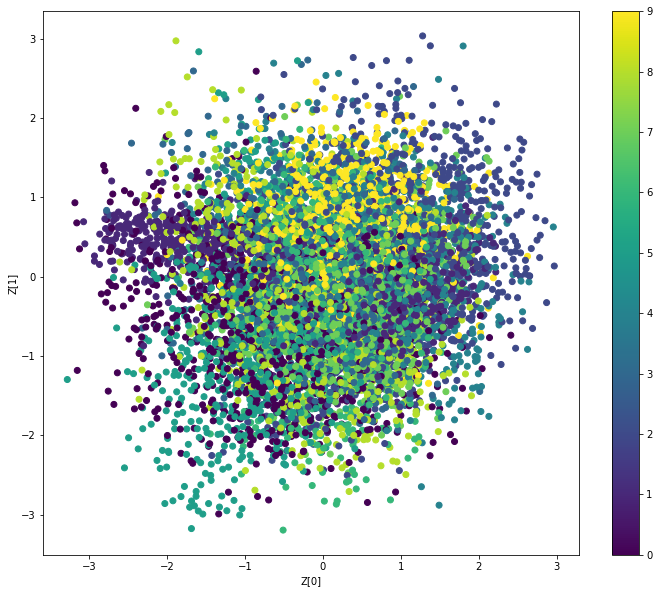

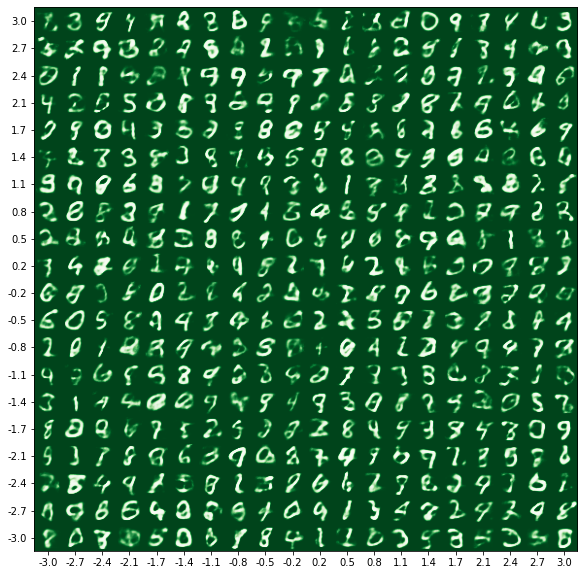

In [50]:
#VAE with 16 code units
i_dim = 256
l_dim = 16 
epochs = 20
vae, encoder, decoder = c_model(i_dim, l_dim)
trained_model = t_model(vae)
plot_ls(encoder)
plot_vae(decoder, l_dim)

# Task 3

In [ ]:
# Loading MNIST Data
(train_x, train_y), (test_x, test_y) = mnist.load_data()
img_size = train_x.shape[1]
train_x = np.reshape(train_x,[-1, img_size,img_size,1])
test_x = np.reshape(test_x,[-1, img_size,img_size,1])
train_x= train_x.astype('float32') / 255
test_x = test_x.astype('float32') / 255
img_shape = (28, 28, 1)
batch = 128

In [ ]:
encoder_inputs = Input(shape=img_shape, name='input_encoder') # Encoder inputs
x = Conv2D(128, 3, padding='same', activation='relu')(encoder_inputs)
x = Conv2D(256, 3, padding='same', activation='relu', strides=(2, 2))(x)
before_flatten_shape= K.int_shape(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
hidden_dimension = 16
mu = Dense(hidden_dimension)(x)
log_var = Dense(hidden_dimension)(x)

In [ ]:
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch, hidden_dimension), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps
z = Lambda(sampling, output_shape=(hidden_dimension,))([mu, log_var])

In [ ]:
encoder = Model(encoder_inputs, [mu, log_var, z], name='encoder') #Encoder

In [ ]:
decoder_inputs = Input(K.int_shape(z)[1:]) #decoder inputs
x = Dense(np.prod(before_flatten_shape[1:]),activation='relu')(decoder_inputs)
x = Reshape(before_flatten_shape[1:])(x)
x = Conv2DTranspose(32, 3,padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(1, 3, padding='same', activation='sigmoid')(x)

In [81]:
decoder = Model(decoder_inputs, x, name='decoder') #decoder
z_decoded = decoder(z)
x = K.flatten(encoder_inputs)
z_decoded = K.flatten(z_decoded)
reconstruction_loss = binary_crossentropy(x, z_decoded)
kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
vae_loss = reconstruction_loss + kl_loss
vae = Model(encoder_inputs, z_decoded)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
epoch = 4
batch =16

vae.fit(x=train_x, y=None,shuffle=True,epochs=epoch,batch_size=batch,validation_data=(test_x, None), verbose=1)

Epoch 1/4
3750/3750 [==============================] - 819s 218ms/step - loss: 0.2670 - val_loss: 0.2639
Epoch 2/4
3750/3750 [==============================] - 773s 206ms/step - loss: 0.2638 - val_loss: 0.2631
Epoch 3/4
3750/3750 [==============================] - 718s 191ms/step - loss: 0.2636 - val_loss: 0.2636
Epoch 4/4
3750/3750 [==============================] - 720s 192ms/step - loss: 0.2635 - val_loss: 0.2631


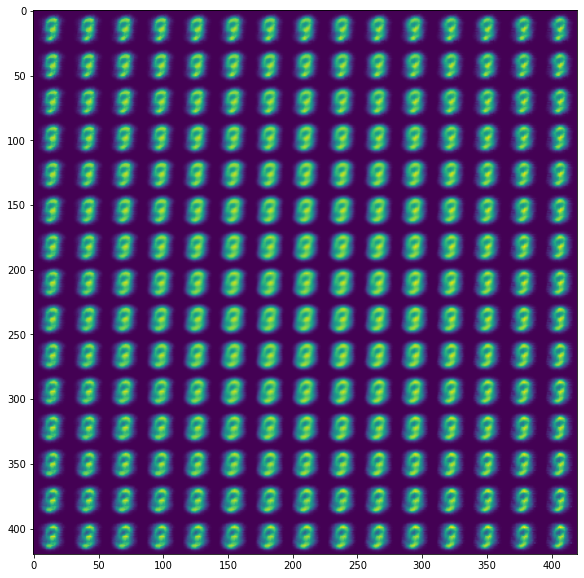

In [82]:
n = 15 
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
rand_x = np.linspace(-3, 3, n) #choosing random variables between -3 and 3
rand_y = np.linspace(-3, 3, n) #choosing random variables between -3 and 3
for i, yi in enumerate(rand_x):
    for j, xi in enumerate(rand_y):
        z_sample = np.array([[xi, yi, xi, yi, xi, yi, xi, yi, xi, yi, xi, yi, xi, yi, xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

# Task 4

In [ ]:
(train_x, train_y), (test_x, test_y) = mnist.load_data() #load data
train_x = train_x.reshape(60000, 784)
test_x = test_x.reshape(10000, 784)
train_x = train_x.astype('float32')/255
test_x = test_x.astype('float32')/255

hidden_dimension = 100

In [ ]:
gan_ = Sequential() #GAN Model
gan_.add(Dense(128, input_dim=hidden_dimension, activation=LeakyReLU(alpha=0.2)))
gan_.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
gan_.add(Dense(784, activation='sigmoid'))
gan_.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
dgan = Sequential() #GAN descriminator
dgan.add(Dense(256, input_dim=784, activation=LeakyReLU(alpha=0.2)))
dgan.add(Dense(128, activation=LeakyReLU(alpha=0.2)))
dgan.add(Dense(1, activation='sigmoid'))
dgan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
dgan.trainable = False
inputs = Input(shape=(hidden_dimension, ))
hidden = gan(inputs)
output = dgan(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

In [ ]:
def plot_f(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, hidden_dimension))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
def GAN():
    epochs=100 
    BATCH_SIZE=128
    batchCount = int(train_x.shape[0] / BATCH_SIZE)
    
    for e in range(1, epochs+1):
        print('Epoch :',e)
        for _ in range(batchCount):
            images_pre = train_x[np.random.randint(0, train_x.shape[0], size=BATCH_SIZE)]
            randomness = np.random.normal(0, 1, size=(BATCH_SIZE, hidden_dimension))
            images_gen = g.predict(randomness)
            X = np.concatenate((images_pre, images_gen))
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.8  
            d.trainable = True
            d_loss = d.train_on_batch(X, y)
            randomness = np.random.normal(0, 1, size=(BATCH_SIZE, hidden_dimension))
            y2 = np.ones(BATCH_SIZE)
            d.trainable = False
            g_loss = gan.train_on_batch(randomness, y2)
        plot_f()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch : 1


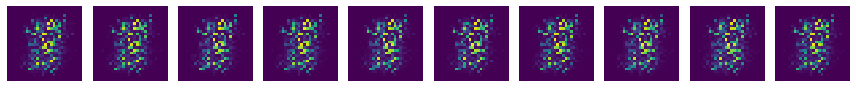

Epoch : 2


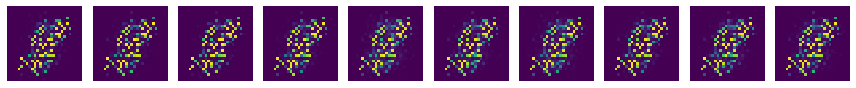

Epoch : 3


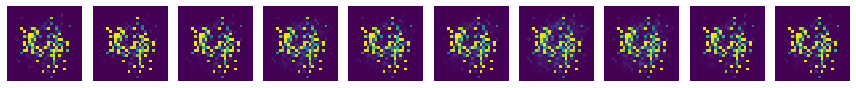

Epoch : 4


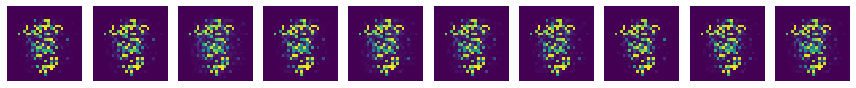

Epoch : 5


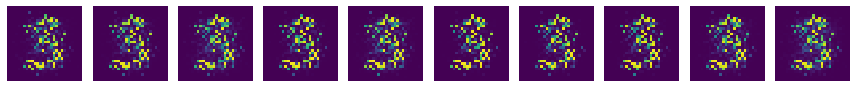

Epoch : 6


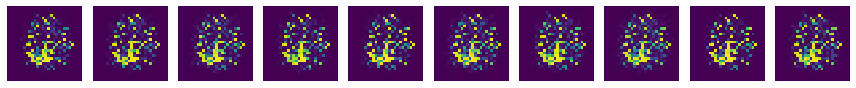

Epoch : 7


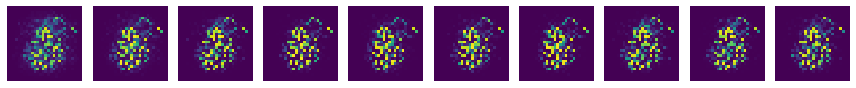

Epoch : 8


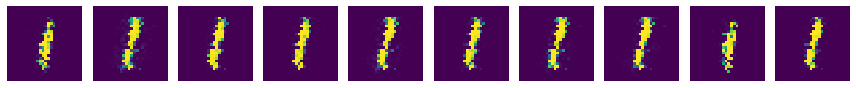

Epoch : 9


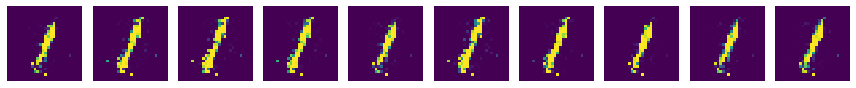

Epoch : 10


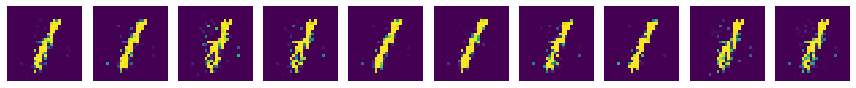

Epoch : 11


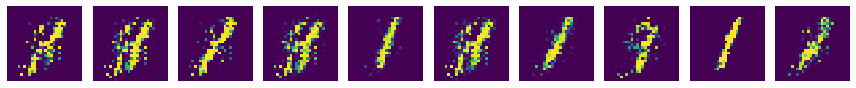

Epoch : 12


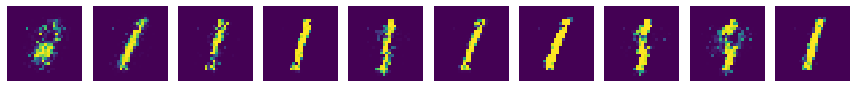

Epoch : 13


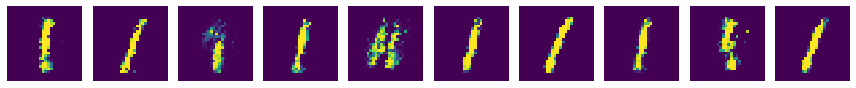

Epoch : 14


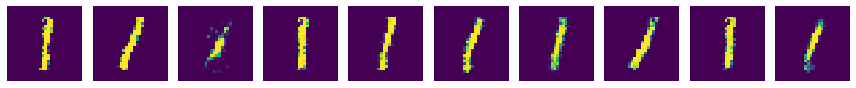

Epoch : 15


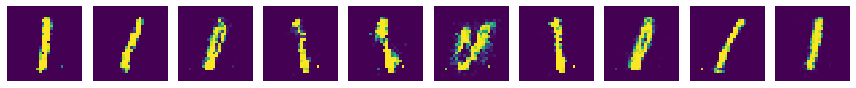

Epoch : 16


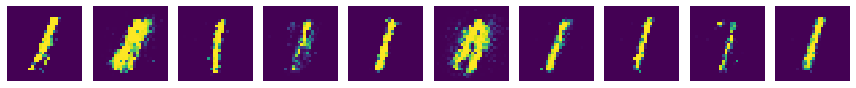

Epoch : 17


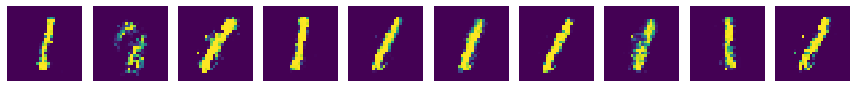

Epoch : 18


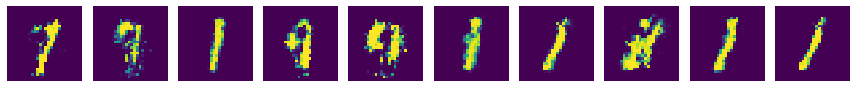

Epoch : 19


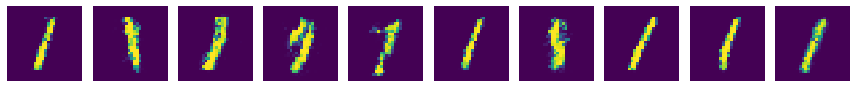

Epoch : 20


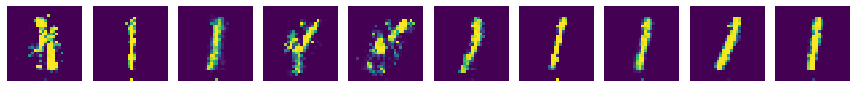

Epoch : 21


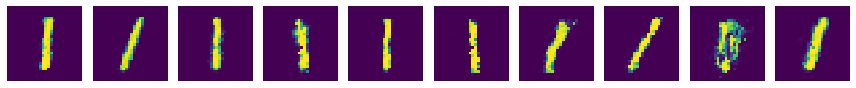

Epoch : 22


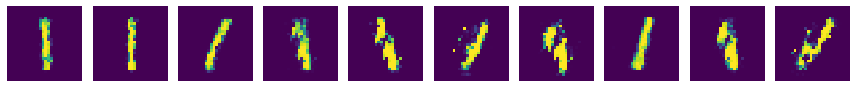

Epoch : 23


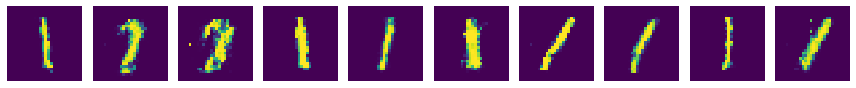

Epoch : 24


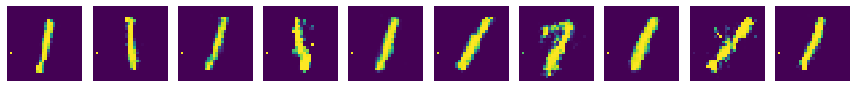

Epoch : 25


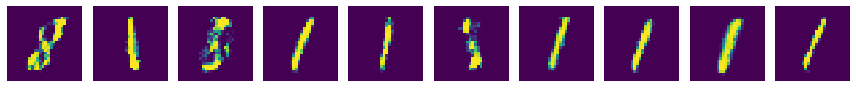

Epoch : 26


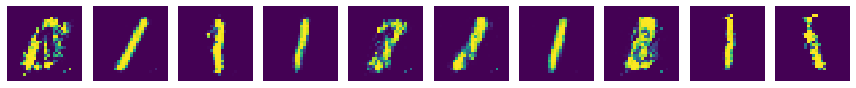

Epoch : 27


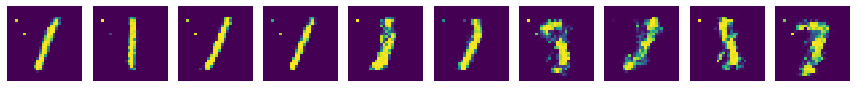

Epoch : 28


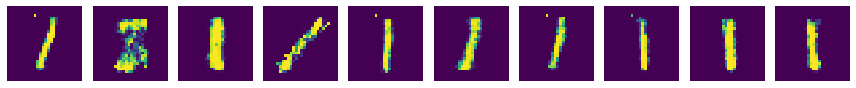

Epoch : 29


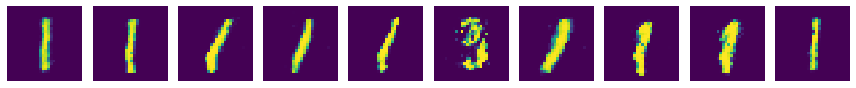

Epoch : 30


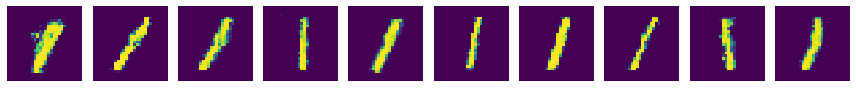

Epoch : 31


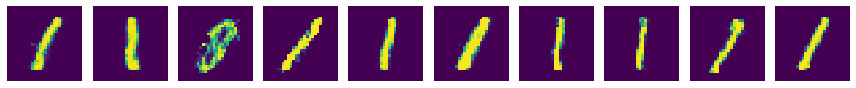

Epoch : 32


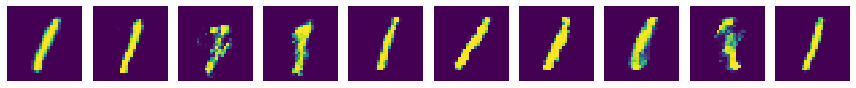

Epoch : 33


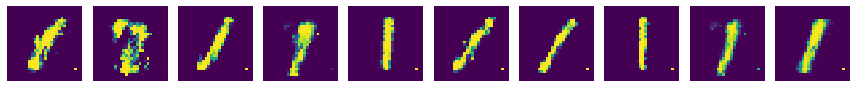

Epoch : 34


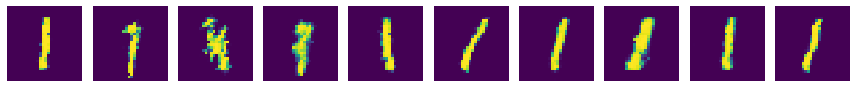

Epoch : 35


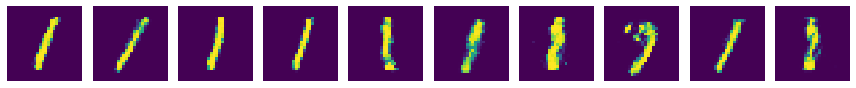

Epoch : 36


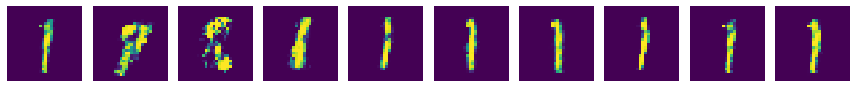

Epoch : 37


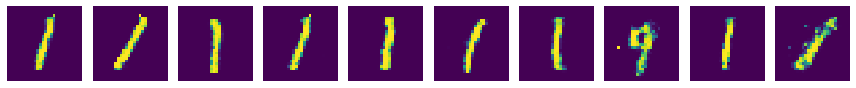

Epoch : 38


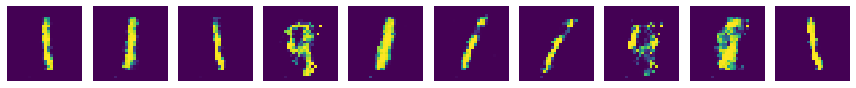

Epoch : 39


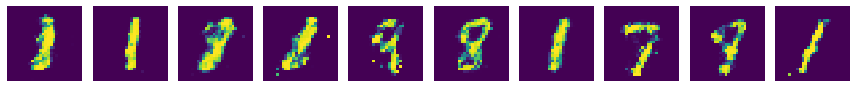

Epoch : 40


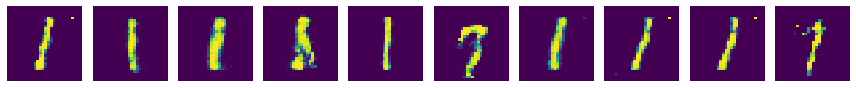

Epoch : 41


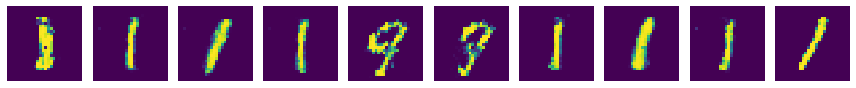

Epoch : 42


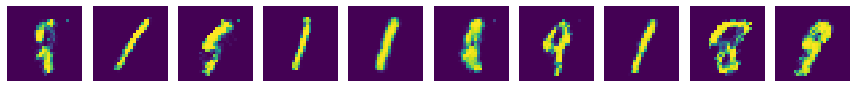

Epoch : 43


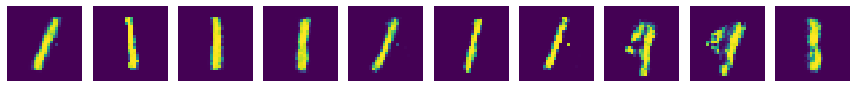

Epoch : 44


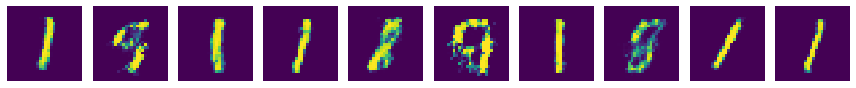

Epoch : 45


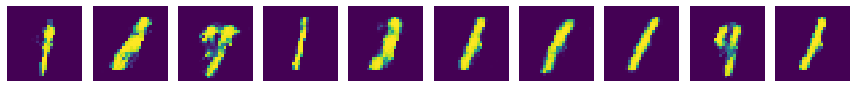

Epoch : 46


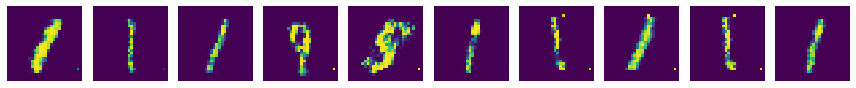

Epoch : 47


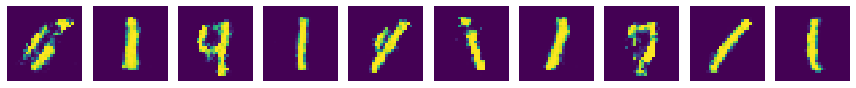

Epoch : 48


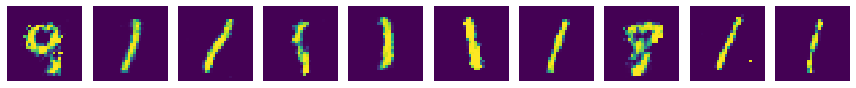

Epoch : 49


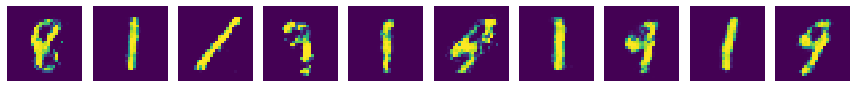

Epoch : 50


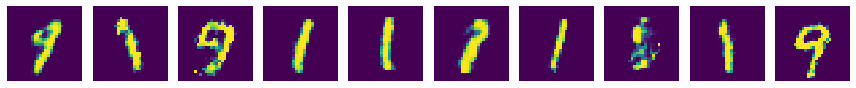

Epoch : 51


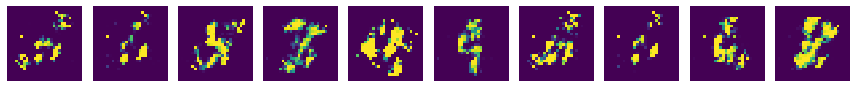

Epoch : 52


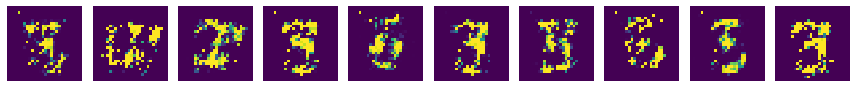

Epoch : 53


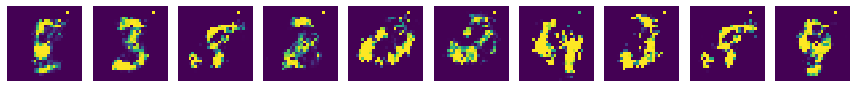

Epoch : 54


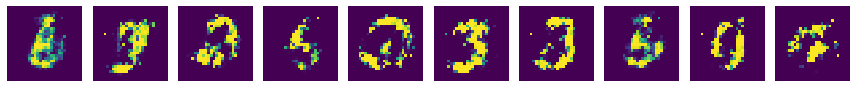

Epoch : 55


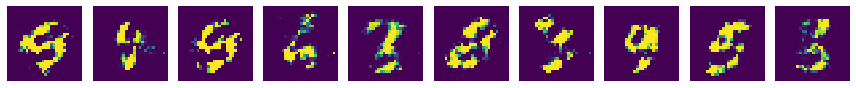

Epoch : 56


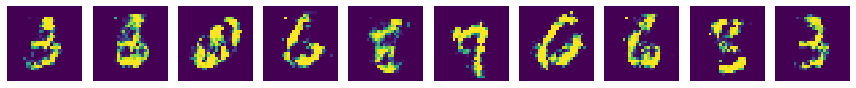

Epoch : 57


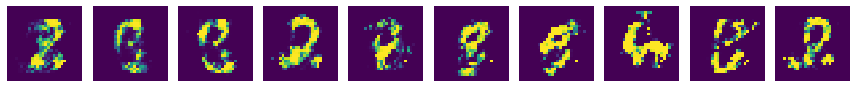

Epoch : 58


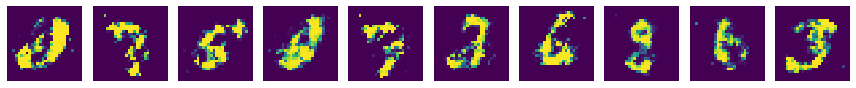

Epoch : 59


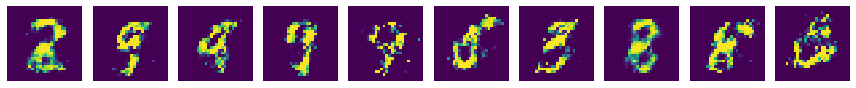

Epoch : 60


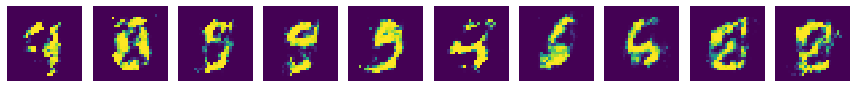

Epoch : 61


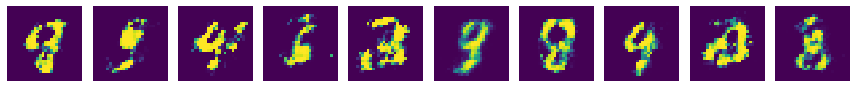

Epoch : 62


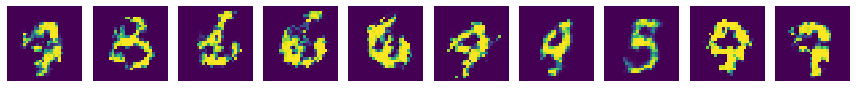

Epoch : 63


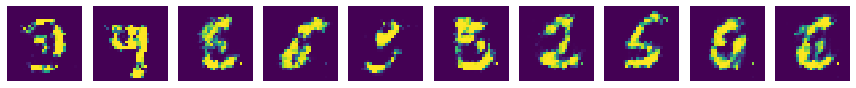

Epoch : 64


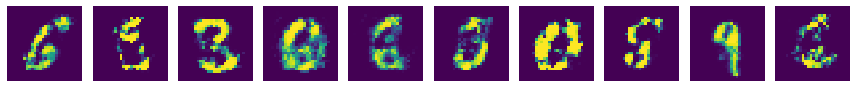

Epoch : 65


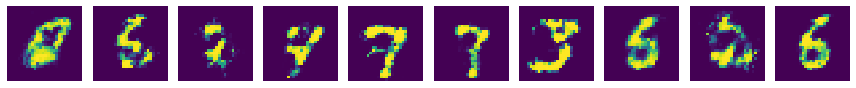

Epoch : 66


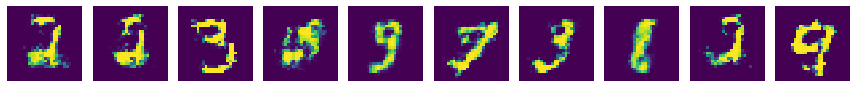

Epoch : 67


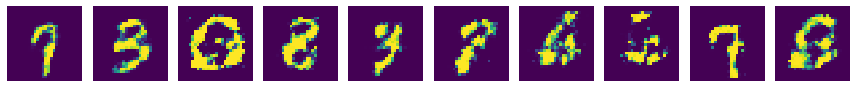

Epoch : 68


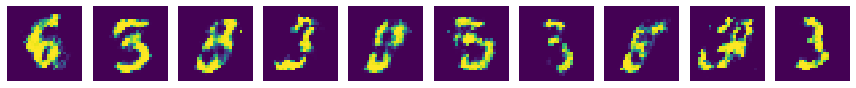

Epoch : 69


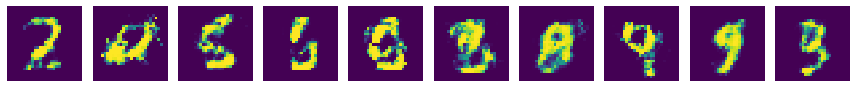

Epoch : 70


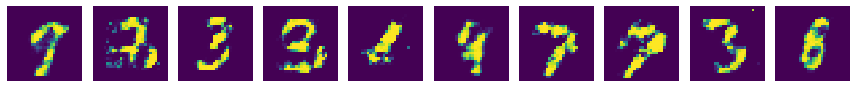

Epoch : 71


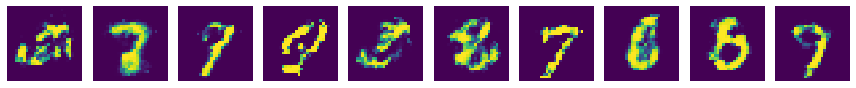

Epoch : 72


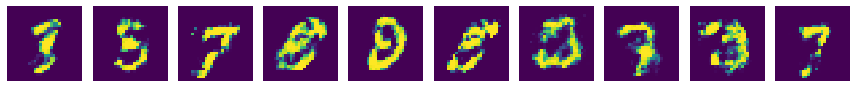

Epoch : 73


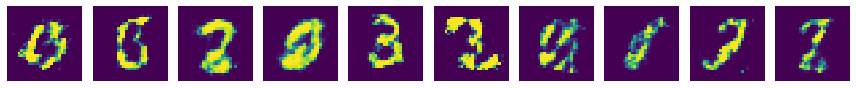

Epoch : 74


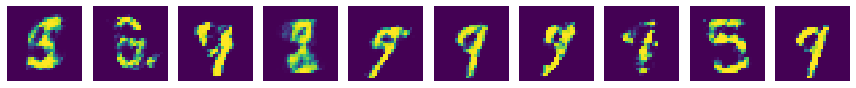

Epoch : 75


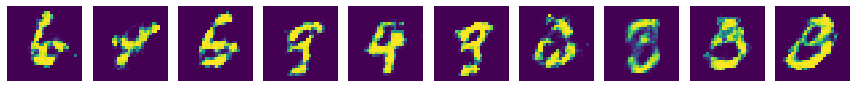

Epoch : 76


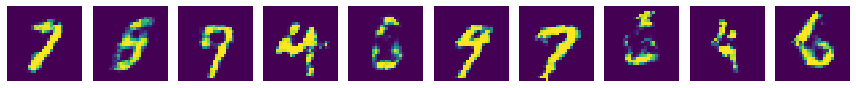

Epoch : 77


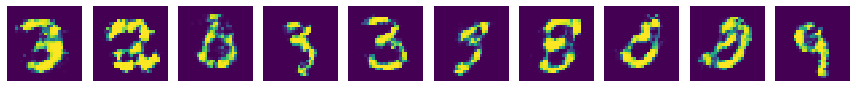

Epoch : 78


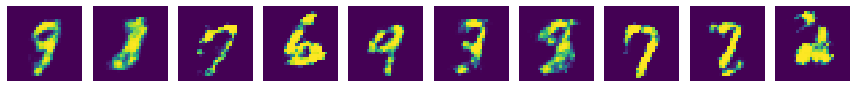

Epoch : 79


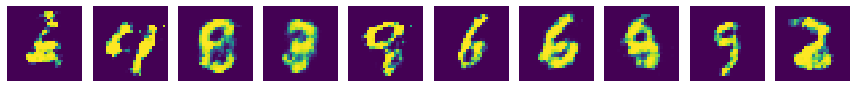

Epoch : 80


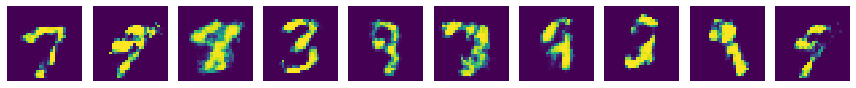

Epoch : 81


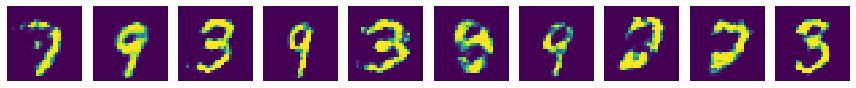

Epoch : 82


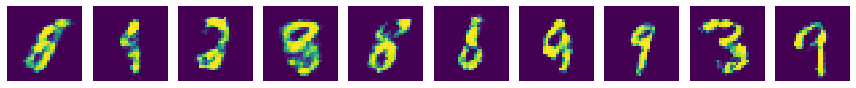

Epoch : 83


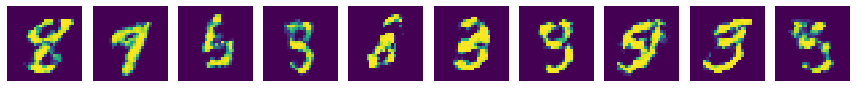

Epoch : 84


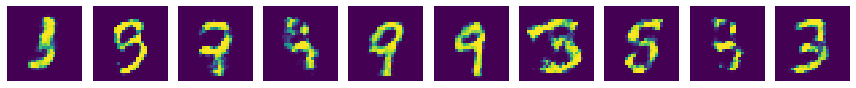

Epoch : 85


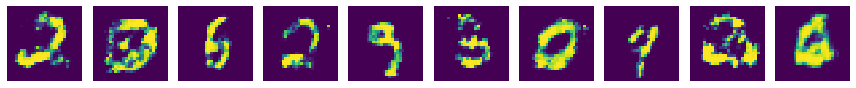

Epoch : 86


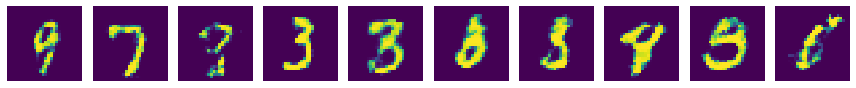

Epoch : 87


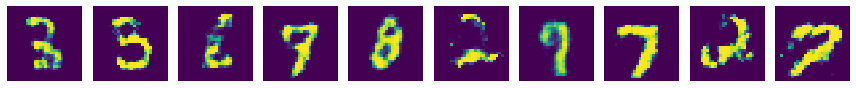

Epoch : 88


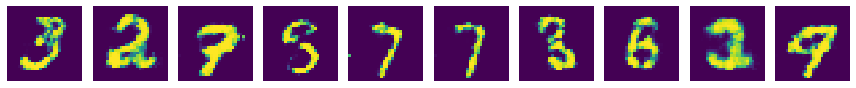

Epoch : 89


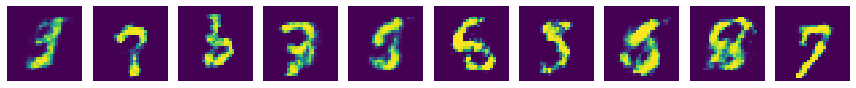

Epoch : 90


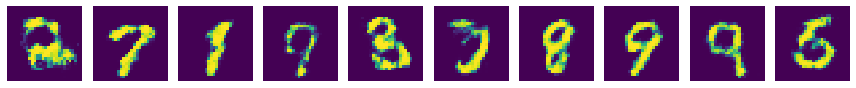

Epoch : 91


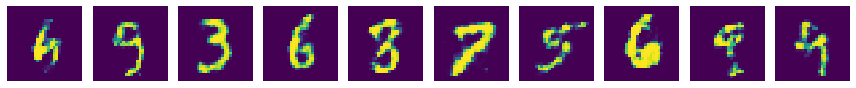

Epoch : 92


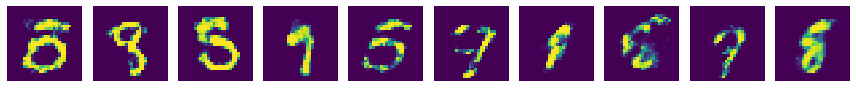

Epoch : 93


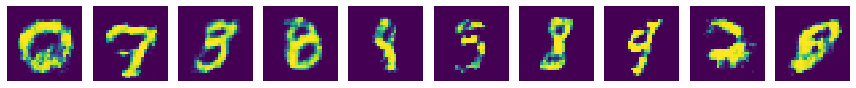

Epoch : 94


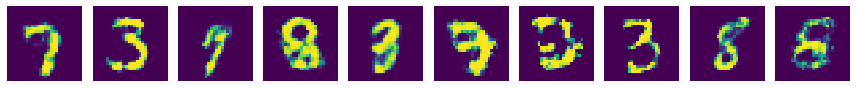

Epoch : 95


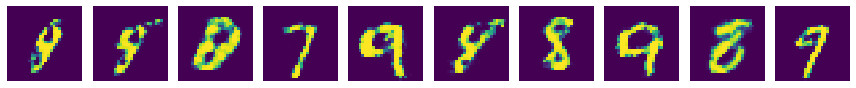

Epoch : 96


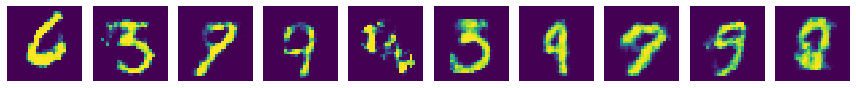

Epoch : 97


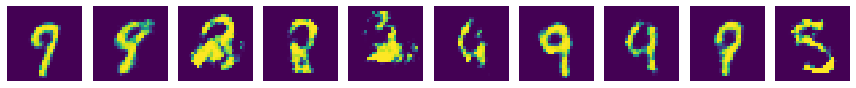

Epoch : 98


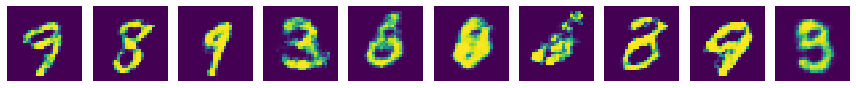

Epoch : 99


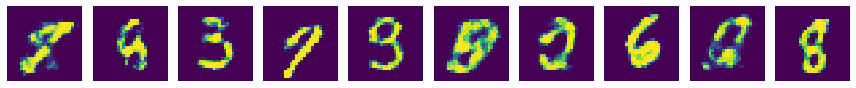

Epoch : 100


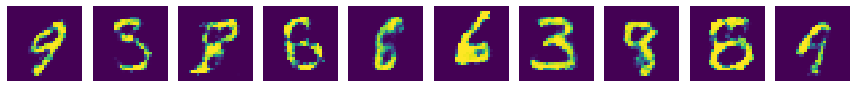

In [40]:
GAN()

# References :

1. Pattern Classification book by Duda, Hart and Stock
2. Class Slides
3. Keras Documentation : https://keras.io/
4. https://towardsdatascience.com/introduction-to-autoencoders-7a47cf4ef14b
5. https://www.ofai.at/~jan.schlueter/pubs/2014_techrep_rbm.pdf
6. https://machinelearningmastery.comhow-to-code-the-generative-adversarial-network-training-algorithm-and-loss-functions/